In [12]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"R:\AIniverse\PROJECTS\mainstream\senti\data\train.csv\train.csv")

# Quick overview
print(df.head())
print(df.info())
print(df.describe())

# Check label distribution
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(df[label_cols].sum())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


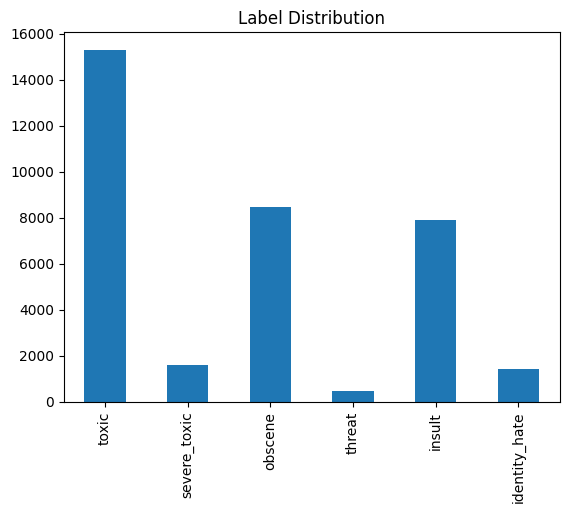

In [13]:
#Check Label Distribution

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Sum of each label
print(df[label_cols].sum())

# Optional: visualize distribution
import matplotlib.pyplot as plt

df[label_cols].sum().plot(kind='bar', title='Label Distribution')
plt.show()


In [14]:
import html
import re
def clean_text(text):
    text = str(text)
    text = html.unescape(text)  # Converts &nbsp; → space, &amp; → &
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"\S+@\S+", "", text)  # Remove emails
    text = re.sub(r"[^a-z\s]", "", text)  # Keep only letters & spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply to dataset
df['comment_text'] = df['comment_text'].apply(clean_text)


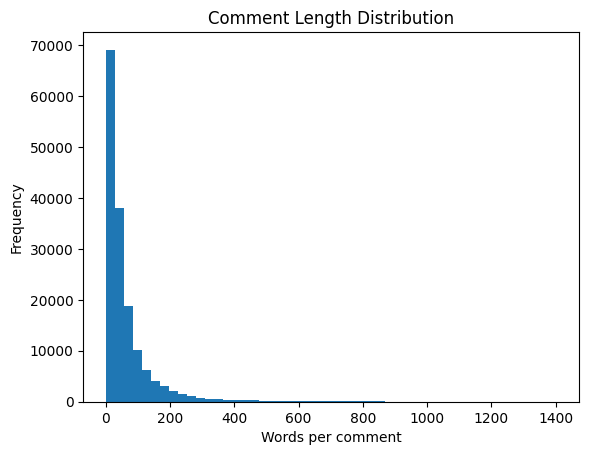

In [15]:
df['comment_length'] = df['comment_text'].apply(lambda x: len(x.split()))
plt.hist(df['comment_length'], bins=50)
plt.title("Comment Length Distribution")
plt.xlabel("Words per comment")
plt.ylabel("Frequency")
plt.show()


In [16]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(len(train_df), len(val_df), len(test_df))


127656 15957 15958


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast
import torch.nn as nn

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_data(df, max_len=128):
    return tokenizer(
        list(df['comment_text']),
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

In [18]:
class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_dataset = ToxicDataset(train_encodings, train_df[label_cols])
val_dataset = ToxicDataset(val_encodings, val_df[label_cols])
test_dataset = ToxicDataset(test_encodings, test_df[label_cols])

In [19]:
class ToxicClassifier(nn.Module):
    def __init__(self):
        super(ToxicClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, len(label_cols))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)
        pooled_output = hidden_state[:, 0]  # [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = ToxicClassifier().to(device)

In [ ]:
from transformers import get_scheduler
import torch
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss()  # Multi-label classification
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

epochs = 30
patience = 2  # early stopping patience
best_val_loss = float('inf')
early_stop_counter = 0

# Scheduler
num_training_steps = epochs * len(train_loader)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

for epoch in range(epochs):
    model.train()
    train_loss = 0

    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # update LR

        train_loss += loss.item()
        loop.set_description(f'Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} validation loss: {avg_val_loss:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_toxicity_model.pt")
        print("✅ Model improved. Saved.")
    else:
        early_stop_counter += 1
        print(f"⚠ No improvement. Early stop counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print("⛔ Early stopping triggered.")
            break


Epoch 1: 100%|██████████| 3990/3990 [21:03<00:00,  3.16it/s, loss=0.00142]


Epoch 1 average loss: 0.0501
Epoch 1 validation loss: 0.0395
✅ Model improved. Saved.


Epoch 2: 100%|██████████| 3990/3990 [21:40<00:00,  3.07it/s, loss=0.105]   


Epoch 2 average loss: 0.0350
Epoch 2 validation loss: 0.0395
⚠ No improvement. Early stop counter: 1/2


Epoch 3:  36%|███▌      | 1428/3990 [12:20<12:33,  3.40it/s, loss=0.0171]    

In [21]:
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from torch.utils.data import DataLoader

# Make sure label_cols is defined
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 1️⃣ Load the saved model (same class as training)
from transformers import DistilBertModel
import torch.nn as nn


class ToxicClassifier(nn.Module):
    def __init__(self):
        super(ToxicClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, len(label_cols))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        pooled_output = hidden_state[:, 0]  # CLS token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


model = ToxicClassifier()
model.load_state_dict(torch.load("best_toxicity_model.pt"))
model.to(device)
model.eval()

# 2️⃣ Prepare test loader (if not already done)
test_loader = DataLoader(test_dataset, batch_size=32)

# 3️⃣ Run predictions
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        outputs = model(input_ids, attention_mask)
        preds = torch.sigmoid(outputs).cpu().numpy()  # sigmoid for multi-label

        all_labels.append(labels)
        all_preds.append(preds)

import numpy as np

all_labels = np.vstack(all_labels)
all_preds = np.vstack(all_preds)

# Convert probabilities to binary predictions (threshold = 0.5)
binary_preds = (all_preds >= 0.5).astype(int)

# 4️⃣ Calculate metrics per label
for i, label in enumerate(label_cols):
    print(f"--- {label} ---")
    print("Accuracy: ", accuracy_score(all_labels[:, i], binary_preds[:, i]))
    print("F1-score:", f1_score(all_labels[:, i], binary_preds[:, i]))
    print("Precision:", precision_score(all_labels[:, i], binary_preds[:, i]))
    print("Recall:", recall_score(all_labels[:, i], binary_preds[:, i]))
    print("ROC-AUC:", roc_auc_score(all_labels[:, i], all_preds[:, i]))
    print()

# 5️⃣ Overall metrics (micro and macro)
print("Micro F1-score:", f1_score(all_labels, binary_preds, average='micro'))
print("Macro F1-score:", f1_score(all_labels, binary_preds, average='macro'))


C:\Users\anmol\AppData\Local\Temp\ipykernel_18948\1210271227.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_toxicity_model.pt"))

--- toxic ---
Accuracy:  0.9679157789196641
F1-score: 0.819718309859155
Precision: 0.8818181818181818
Recall: 0.7657894736842106
ROC-AUC: 0.9866478991841704

--- severe_toxic ---
Accuracy:  0.9904123323724777
F1-score: 0.2679425837320574
Precision: 0.5957446808510638
Recall: 0.1728395061728395
ROC-AUC: 0.9903991946703181

--- obscene ---
Accuracy:  0.9823286126080962
F1-score: 0.8292978208232445
Precision: 0.8605527638190955
Recall: 0.8002336448598131
ROC-AUC: 0.9917750882782129

--- threat ---
Accuracy:  0.9979320716881814
F1-score: 0.4406779661016949
Precision: 0.5909090909090909
Recall: 0.35135135135135137
ROC-AUC: 0.9948920090242871

--- insult ---
Accuracy:  0.9776287755357814
F1-score: 0.771884984025559
Precision: 0.797886393659181
Recall: 0.7475247524752475
ROC-AUC: 0.9903189638270757

--- identity_hate ---
Accuracy:  0.9931695701215691
F1-score: 0.502283105022831
Precision: 0.6790123456790124
Recall: 0.39855072463768115
ROC-AUC: 0.9860983620073653

Micro F1-score: 0.77903422982

In [27]:
import torch
import torch.nn.functional as F

def predict_toxicity(comment, model, tokenizer, device, threshold=0.5):
    # 1️⃣ Clean the comment (reuse your clean_text function)
    comment = clean_text(comment)

    # 2️⃣ Tokenize
    enc = tokenizer(comment, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    input_ids = enc['input_ids'].to(device)
    attention_mask = enc['attention_mask'].to(device)

    # 3️⃣ Model prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()

    # 4️⃣ Prepare clean output
    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    result = {}
    for i, label in enumerate(label_cols):
        pred = int(probs[i] >= threshold)
        result[label] = {"prob": float(probs[i]), "pred": pred, "label": "Yes" if pred else "No"}

    # 5️⃣ Print neatly
    print(f"\nComment: {comment}\n")
    for label in label_cols:
        print(f"{label:15}: {result[label]['label']:3} (prob: {result[label]['prob']:.2f})")

    return result

comment = "you piece of shit!"
predict_toxicity(comment, model, tokenizer, device)



Comment: you peice of shit

toxic          : Yes (prob: 0.98)
severe_toxic   : No  (prob: 0.07)
obscene        : Yes (prob: 0.90)
threat         : No  (prob: 0.01)
insult         : Yes (prob: 0.78)
identity_hate  : No  (prob: 0.01)


{'toxic': {'prob': 0.983859658241272, 'pred': 1, 'label': 'Yes'},
 'severe_toxic': {'prob': 0.06879701465368271, 'pred': 0, 'label': 'No'},
 'obscene': {'prob': 0.9023116230964661, 'pred': 1, 'label': 'Yes'},
 'threat': {'prob': 0.005150164477527142, 'pred': 0, 'label': 'No'},
 'insult': {'prob': 0.7836145758628845, 'pred': 1, 'label': 'Yes'},
 'identity_hate': {'prob': 0.01201742421835661, 'pred': 0, 'label': 'No'}}

In [25]:
my_comment = "I hate you and you are awful!"
print(my_comment)
predict_toxicity(my_comment, model, tokenizer, device)


I hate you and you are awful!


{'toxic': {'prob': 0.92925614, 'pred': 1},
 'severe_toxic': {'prob': 0.009598553, 'pred': 0},
 'obscene': {'prob': 0.053453792, 'pred': 0},
 'threat': {'prob': 0.017813405, 'pred': 0},
 'insult': {'prob': 0.38485777, 'pred': 0},
 'identity_hate': {'prob': 0.014189898, 'pred': 0}}